# Isotope-labelled models

Label models include isotopomers of each compound. 
*modelbase* can auto-generate all possible `2^n` compound variants and all possible reaction transitions between them.


To set the amount of label positions and auto-generate all variants you declare the `labelcompounds` using a dictionary.

```python
labelcompounds = {"GAP": 3, "DHAP": 3, "FBP": 6}
```


After that you need to create the `labelmaps`, which encode **from which substrate atom a product atom is formed**.

As an example let's take triose phosphate isomerase, which catalyzes the interconversion of glyceraldehyde 3-phosphate (GAP) and dihydroxyacetone phosphate (DHAP).  
As illustrated below, in the case of the forward reaction the first and last carbon atoms are swapped

<img src="assets/carbon-maps.png" style="max-width: 25%">

So DHAP(1) is build from GAP(3), DHAP(2) from GAP(2) and DHAP(3) from GAP(1).  
We notate this using normal 0-based indexing as follows

```python
labelmaps = {"TPIf": [2, 1, 0]}
```

Lastly, there are two different flavours of isotope-labelled models in modelbase.  
The **LabelModel** assumes no metabolic steady-state, while the **LinearLabelModel** requires steady-state fluxes as an input.  
The linear version is much faster to compute, but less flexible.  
Since both cases might be needed, the easiest way to build either of them is to build a normal model first and then let the other two variants be auto-generated using only the label compounds and label maps as additional information.

In [1]:
from modelbase.ode import Model, Simulator, _LinearLabelSimulate, _LabelSimulate

import matplotlib.pyplot as plt

## Creation from model

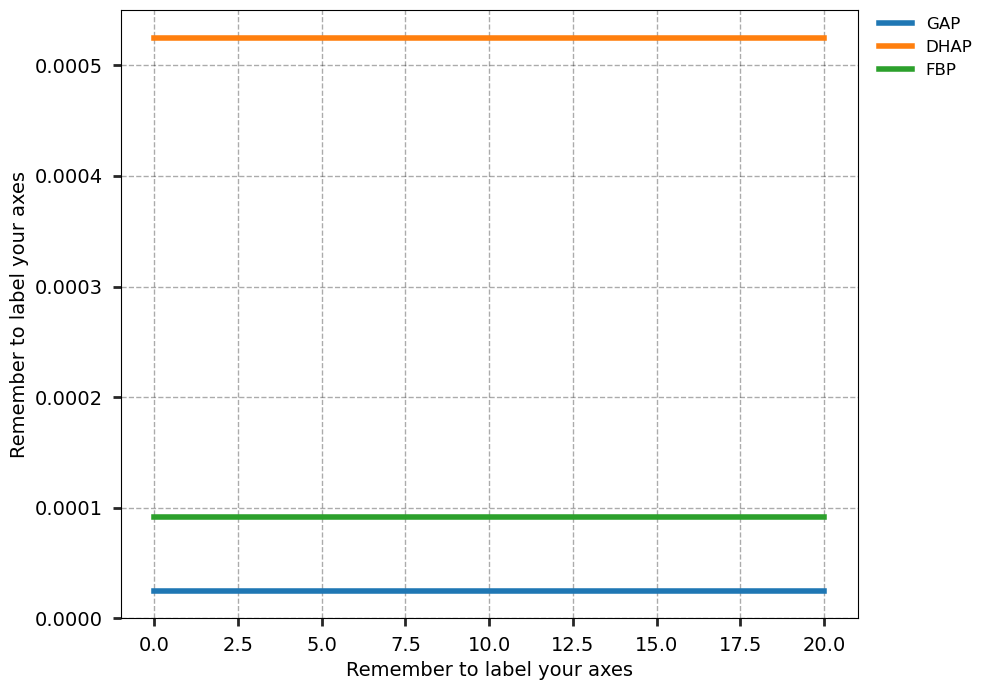

In [2]:
p = {
    "kf_TPI": 1.0,
    "Keq_TPI": 21.0,
    "kf_Ald": 2000.0,
    "Keq_Ald": 7000.0,
}

GAP0 = 2.5e-5
DHAP0 = GAP0 * p["Keq_TPI"]
FBP0 = GAP0 * DHAP0 * p["Keq_Ald"]

base_y0 = {"GAP": GAP0, "DHAP": DHAP0, "FBP": FBP0}

p["kr_TPI"] = p["kf_TPI"] / p["Keq_TPI"]
p["kr_Ald"] = p["kf_Ald"] / p["Keq_Ald"]


def mass_action_1(kf, s):
    return kf * s


def mass_action_2(kf, s1, s2):
    return kf * s1 * s2


m = Model()
m.add_compounds(["GAP", "DHAP", "FBP"])
m.add_parameters(p)
m.add_reaction_from_args("TPIf", mass_action_1, {"GAP": -1, "DHAP": 1}, ["kf_TPI", "GAP"])
m.add_reaction_from_args(
    "TPIr", mass_action_1, {"DHAP": -1, "GAP": 1}, ["kr_TPI", "DHAP"]
)
m.add_reaction_from_args(
    "ALDf", mass_action_2, {"DHAP": -1, "GAP": -1, "FBP": 1}, ["kf_Ald", "DHAP", "GAP"]
)
m.add_reaction_from_args(
    "ALDr",
    mass_action_1,
    {
        "FBP": -1,
        "DHAP": 1,
        "GAP": 1,
    },
    ["kr_Ald", "FBP"],
)

# Simulate
s = Simulator(m)
s.initialise(base_y0)
t, y = s.simulate(20)
s.plot()
plt.show()

### Creating the LabelModel

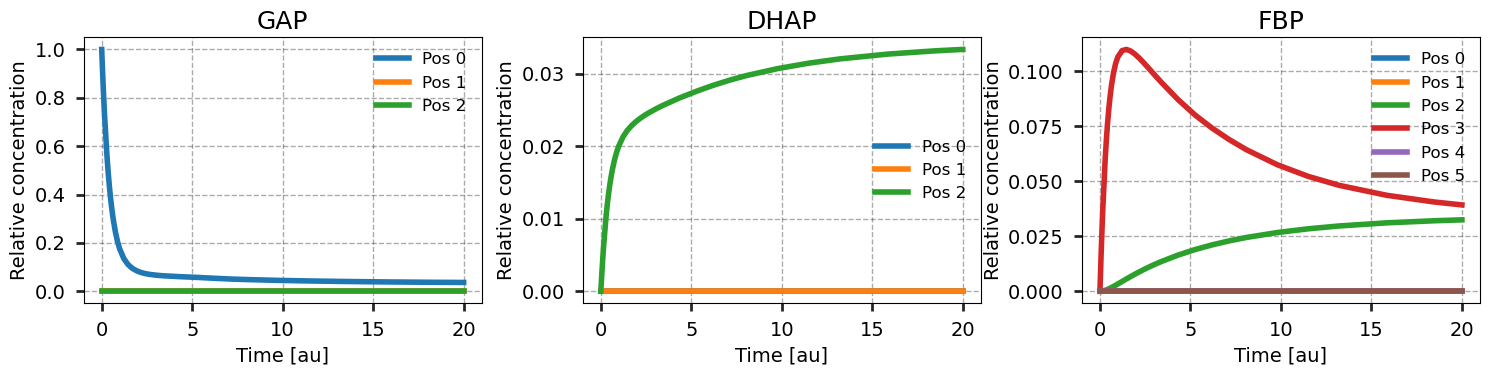

In [3]:
lm = m.to_labelmodel(
    labelcompounds={"GAP": 3, "DHAP": 3, "FBP": 6},
    labelmaps={
        "TPIf": [2, 1, 0],
        "TPIr": [2, 1, 0],
        "ALDf": [0, 1, 2, 3, 4, 5],
        "ALDr": [0, 1, 2, 3, 4, 5],
    },
)


# Simulate
y0 = lm.generate_y0(base_y0, label_positions={"GAP": 0})
ls: _LabelSimulate = Simulator(lm)
ls.initialise(y0)
t, y = ls.simulate(20)
fig, ax = ls.plot_label_distribution_grid(
    ["GAP", "DHAP", "FBP"],
    ncols=3,
    sharey=False,
    relative=True,
    xlabels="Time [au]",
)
plt.show()

### Creating the LinearLabelModel

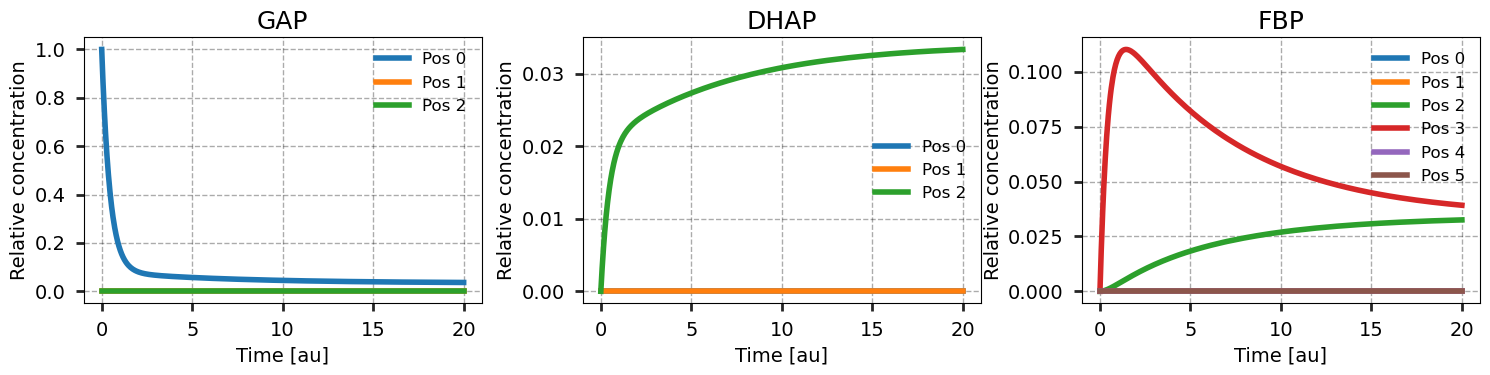

In [4]:
y_ss = base_y0  # in this case the initial conditions are already in steady state
v_ss = {k: v[0] for k, v in m.get_fluxes_dict(y_ss).items()}

llm = m.to_linear_labelmodel(
    labelcompounds={"GAP": 3, "DHAP": 3, "FBP": 6},
    labelmaps={
        "TPIf": [2, 1, 0],
        "TPIr": [2, 1, 0],
        "ALDf": [0, 1, 2, 3, 4, 5],
        "ALDr": [0, 1, 2, 3, 4, 5],
    },
)

# Simulate
y0 = llm.generate_y0(initial_labels={"GAP": 0})
lls: _LinearLabelSimulate = Simulator(llm)
lls.initialise(y0, y_ss, v_ss)
t, y = lls.simulate(20)
fig, ax = lls.plot_label_distribution_grid(
    ["GAP", "DHAP", "FBP"],
    ncols=3,
    sharey=False,
    xlabels="Time [au]",
)
plt.show()

## Label Scopes

In [5]:
lm.get_label_scope({"GAP": 0})

{0: {'DHAP__001', 'FBP__000100'}, 1: {'FBP__001000', 'FBP__001100'}}